## Why are we learning about decision trees?
- Can be applied to both regression and classification problems
- Many useful properties
- Very popular
- Basis for more sophisticated models
- Have a different way of "thinking" than the other models we have studied

# Regression trees

Major League Baseball player data from 1986-87:

- __Years (x-axis)__: number of years playing in the major leagues
- __Hits (y-axis)__: number of hits in the previous year
- __Salary (color)__: low salary is blue/green, high salary is red/yellow

## Building a regression tree by hand

Your training data is a tiny dataset of used vehicle sale prices. Your goal is to predict price for testing data.

1. Read the data into a Pandas DataFrame.
2. Explore the data by sorting, plotting, or split-apply-combine (aka group_by).
3. Decide which feature is the most important predictor, and use that to create your first splitting rule.
   - Only binary splits are allowed.
4. After making your first split, split your DataFrame into two parts, and then explore each part to figure out what other splits to make.
5. Stop making splits once you are convinced that it strikes a good balance between underfitting and overfitting.
   - Your goal is to build a model that generalizes well.
   - You are allowed to split on the same variable multiple times!
6. Draw your tree, labeling the leaves with the mean price for the observations in that region.
   - Make sure nothing is backwards: You follow the left branch if the rule is true, and the right branch if the rule is false.

## How does a computer build a regression tree?
__Ideal approach: Consider every possible partition of the feature space (computationally infeasible)__

"Good enough" approach: __recursive binary splitting__

1. Begin at the top of the tree.
2. For every feature, examine every possible cutpoint, and choose the feature and cutpoint such that __the resulting tree has the lowest possible mean squared error (MSE)__. Make that split.
3. Examine the two resulting regions, and again make a single split (in one of the regions) to minimize the MSE.
4. Keep repeating step 3 until a stopping criterion is met:
   - __maximum tree depth (maximum number of splits required to arrive at a leaf)__
   - minimum number of observations in a leaf


## Demo: Choosing the ideal cutpoint for a given feature

In [60]:
# vehicle data
import pandas as pd
import zipfile
with zipfile.ZipFile("vehicles_train.csv.zip", 'r') as z:
    f = z.open('vehicles_train.csv')
    train = pd.io.parsers.read_table(f, index_col=False, sep=',')

In [61]:
# before splitting anything, just predict the mean of the entire dataset
train['predictor']=train.price.mean()
train

price  year   miles  doors  vtype    predictor
0   22000  2012   13000      2    car  6571.428571
1   14000  2010   30000      2    car  6571.428571
2   13000  2010   73500      4    car  6571.428571
3    9500  2009   78000      4    car  6571.428571
4    9000  2007   47000      4    car  6571.428571
5    4000  2006  124000      2    car  6571.428571
6    3000  2004  177000      4    car  6571.428571
7    2000  2004  209000      4  truck  6571.428571
8    3000  2003  138000      2    car  6571.428571
9    1900  2003  160000      4    car  6571.428571
10   2500  2003  190000      2  truck  6571.428571
11   5000  2001   62000      4    car  6571.428571
12   1800  1999  163000      2  truck  6571.428571
13   1300  1997  138000      4    car  6571.428571

In [62]:
year=0
train['pred']=train.loc[train.year<year, 'price'].mean()
train.loc[train.year>=year, 'pred'] = train.loc[train.year>=year, 'price'].mean()
(((train['price'] - train['pred'])**2).mean()) ** 0.5

5936.981985995983

In [63]:
train_izq.year.unique()

NameError: name 'train_izq' is not defined

In [64]:
#lowest possible mean squared error (MSE)
def error_year(train,year):
    train['pred']=train.loc[train.year<year, 'price'].mean()
    train.loc[train.year>=year, 'pred'] = train.loc[train.year>=year, 'price'].mean()
    return round(((((train['price'] - train['pred'])**2).mean()) ** 0.5), 2)

In [65]:
#lowest possible mean squared error (MSE)
def error_miles(train, miles):
    train['pred'] = train.loc[train.miles<miles, 'price'].mean()
    train.loc[train.miles>=miles, 'pred'] = train.loc[train.miles>=miles, 'price'].mean()
    return round(((((train['price'] - train['pred'])**2).mean()) ** 0.5), 2)

__Recap__: Before every split, this process is repeated for every feature, and the feature and cutpoint that produces the lowest MSE is chosen.

# Building a regression tree in scikit-learn

In [66]:
# encode car as 0 and truck as 1
train['vtype']=train.vtype.map({'car':0, 'truck':1})

In [67]:
# define X and y
feature_cols=['year', 'miles', 'doors', 'vtype']
X=train[feature_cols]
y=train.price

In [68]:
# instantiate a DecisionTreeRegressor (with random_state=1)
from sklearn.tree import DecisionTreeRegressor
treereg=DecisionTreeRegressor(random_state=1)
treereg


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [69]:
# use leave-one-out cross-validation (LOOCV) to estimate the RMSE for this model
import numpy as np
from sklearn.model_selection import cross_val_score
scores=cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

3107.1428571428573

# Tuning a regression tree

Let's try to reduce the RMSE by tuning the max_depth parameter:

In [70]:
# try different values one-by-one
treereg = DecisionTreeRegressor(max_depth=1, random_state=1)
scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

4050.1443001442999

Or, we could write a loop to try a range of values:

In [71]:
# list of values to try
max_depth_range=range(1,8)

# list to store the average RMSE for each value of max_depth
RMSE_scores=[]
# use LOOCV with each value of max_depth
for depth in max_depth_range:
    treereg=DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

Text(0,0.5,'RMSE (lower is better)')

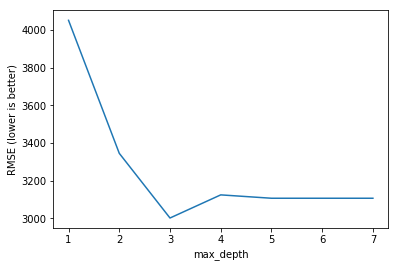

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

In [73]:

# max_depth=3 was best, so fit a tree using that parameter# max_de
treereg=DecisionTreeRegressor(max_depth=3, random_state=1)
treereg.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [74]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

feature  importance
0    year    0.798744
1   miles    0.201256
2   doors    0.000000
3   vtype    0.000000

# Creating a tree diagram

In [75]:
# create a Graphviz file
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file='tree_vehicles.dot', feature_names=feature_cols)
# At the command line, run this to convert to PNG:
import pydot
(graph,) = pydot.graph_from_dot_file('tree_vehicles.dot')
graph.write_png('tree_vehicles.png')
# dotb- Tpng tree_vehicles.dot -o tree_vehicles.png

ModuleNotFoundError: No module named 'pydot'

__Reading the internal nodes__:

samples: number of observations in that node before splitting

mse: MSE calculated by comparing the actual response values in that node against the mean response value in that node

rule: rule used to split that node (go left if true, go right if false)

__Reading the leaves__:

samples: number of observations in that node

value: mean response value in that node

mse: MSE calculated by comparing the actual response values in that node against "value"

# Making predictions for the testing data

In [76]:
# read the testing data
with zipfile.ZipFile("vehicles_test.csv.zip", 'r') as z:
    f = z.open('vehicles_test.csv')
    test = pd.io.parsers.read_table(f, index_col=False, sep=',')

In [77]:
# encode car as 0 and truck as 1
test['vtype']=test.vtype.map({'car':0, 'truck':1})
test

price  year   miles  doors  vtype
0   3000  2003  130000      4      1
1   6000  2005   82500      4      0
2  12000  2010   60000      2      0

Question: Using the tree diagram above, what predictions will the model make for each observation?

In [78]:
# use fitted model to make predictions on testing data
X_test=test[feature_cols]
y_test=test.price
y_pred=treereg.predict(X_test)
y_pred

array([  4000.,   5000.,  13500.])

In [79]:
# calculate RMSE
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, y_pred))

1190.2380714238084

# Classification trees

## Splitting criteria for classification trees

Common options for the splitting criteria:

classification error rate: fraction of training observations in a region that don't belong to the most common class
Gini index: measure of total variance across classes in a region

## Building a classification tree in scikit-learn

We'll build a classification tree using the Titanic data:

In [80]:
# read in the data
with zipfile.ZipFile("titanic.csv.zip", 'r') as z:
    f = z.open('titanic.csv')
    titanic = pd.read_csv(f, sep=',', index_col=0)

In [81]:
# encode female as 0 and male as 1
titanic['Sex']=titanic.Sex.map({'female':0, 'male':1})
# fill in the missing values for age with the median age
titanic.Age.fillna(titanic.Age.median(), inplace=True)

In [82]:
# create a DataFrame of dummy variables for Embarked
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked')
embarked_dummies.drop(embarked_dummies.columns[0], axis=1, inplace=True)


In [83]:
# concatenate the original DataFrame and the dummy DataFrame
titanic = pd.concat([titanic, embarked_dummies], axis=1)

In [84]:
# print the updated DataFrame
titanic.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name  Sex   Age  \
PassengerId                                                                 
1                                      Braund, Mr. Owen Harris    1  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0   
3                                       Heikkinen, Miss. Laina    0  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.0   
5                                     Allen, Mr. William Henry    1  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  \
PassengerId                                                           
1                1      0         A/5 21171   7.2500   NaN        S   
2                1      0          PC 17599  71.2833   C85        C   
3                0      0  STON/O2. 3101282   7.9250   NaN        S   
4                1      0            113803  53.1000  C123        S   
5                0      0            373450   8.0500   NaN        S   

             Embarked_Q  Embarked_S  
PassengerId                          
1                     0           1  
2                     0           0  
3                     0           1  
4                     0           1  
5                     0           1

- Survived: 0=died, 1=survived (response variable)
- Pclass: 1=first class, 2=second class, 3=third class

What will happen if the tree splits on this feature?
- Sex: 0=female, 1=male
- Age: numeric value
- Embarked: C or Q or S

In [85]:
# define X and y
feature_cols = ['Pclass', 'Sex', 'Age', 'Embarked_Q', 'Embarked_S']
X = titanic[feature_cols]
y = titanic.Survived

In [88]:
# fit a classification tree with max_depth=3 on all data
from sklearn.tree import DecisionTreeClassifier
treeclf=DecisionTreeClassifier(max_depth=3,  random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [89]:
# create a Graphviz file
export_graphviz(treeclf, out_file='tree_titanic.dot', feature_names=feature_cols)

# At the command line, run this to convert to PNG:
#   dot -Tpng tree_titanic.dot -o tree_titanic.png

In [90]:
# compute the feature importances
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

feature  importance
0      Pclass    0.242664
1         Sex    0.655584
2         Age    0.064494
3  Embarked_Q    0.000000
4  Embarked_S    0.037258